# LSTM Example
An introduction to LSTM Forecasting in scalecast. The following concepts are covered:  
1. Exploratory Data Analysis  
2. Default LSTM models  
3. Adding parameters to LSTM models  
4. Adding droput to LSTM models  
5. Differencing series  
6. Forecasting with Multiple Linear Regression  
7. Model benchmarking  
8. Feature Importance  

- data: https://www.kaggle.com/datasets/rakannimer/air-passengers
- blog post: https://towardsdatascience.com/exploring-the-lstm-neural-network-model-for-time-series-8b7685aa8cf

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scalecast.Forecaster import Forecaster

sns.set(rc={'figure.figsize':(12,8)})

In [2]:
data = pd.read_csv('AirPassengers.csv',parse_dates=['Month'])

## EDA

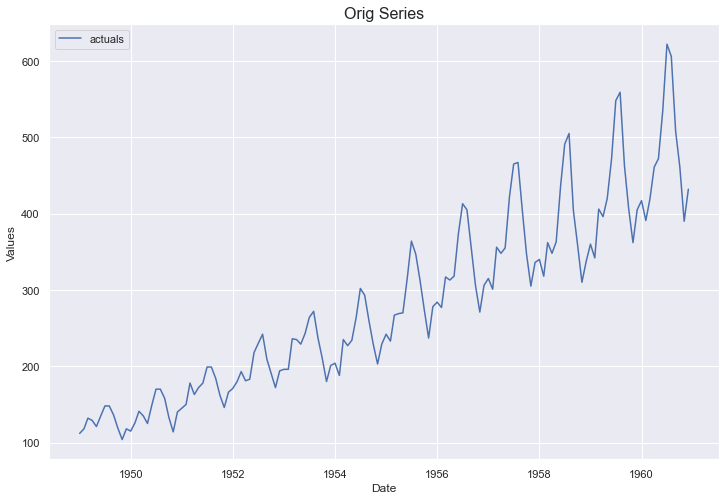

In [3]:
f = Forecaster(y=data['#Passengers'],current_dates=data['Month'])
f.plot()
plt.title('Orig Series',size=16)
plt.show()

In [4]:
f

Forecaster(
    DateStartActuals=1949-01-01T00:00:00.000000000
    DateEndActuals=1960-12-01T00:00:00.000000000
    Freq=MS
    N_actuals=144
    ForecastLength=0
    Xvars=[]
    Differenced=0
    TestLength=1
    ValidationLength=1
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=0.95
    BootstrapSamples=100
    CurrentEstimator=None
)

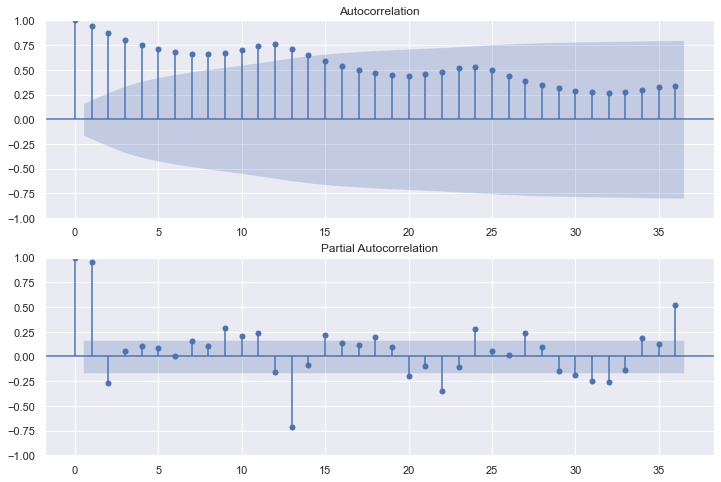

In [5]:
figs, axs = plt.subplots(2, 1)
f.plot_acf(ax=axs[0],lags=36)
f.plot_pacf(ax=axs[1],lags=36)
plt.show()

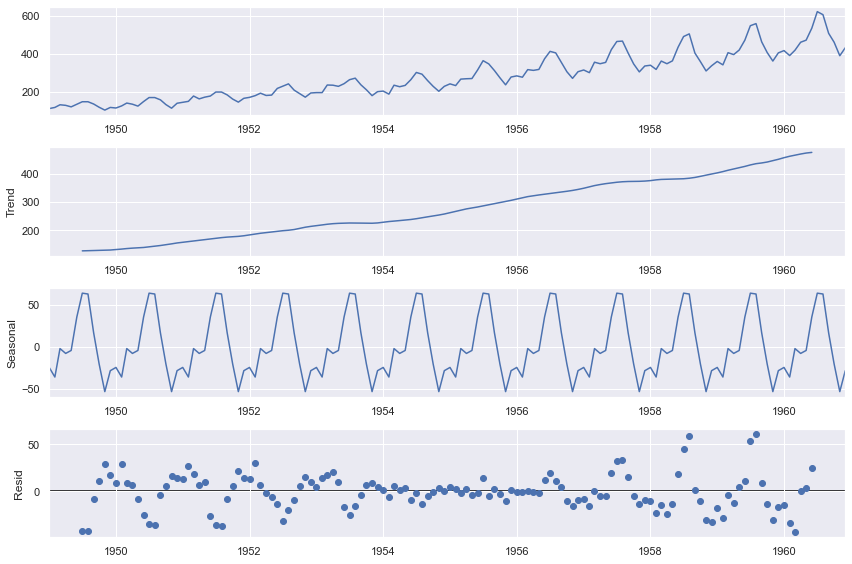

In [6]:
f.seasonal_decompose().plot()
plt.show()

The below shows the results of the ADF test indicate the series is not stationary.

In [7]:
critical_pval = 0.05
print('-'*100)
print('Augmented Dickey-Fuller results:')
stat, pval, _, _, _, _ = f.adf_test(full_res=True)
print('the test-stat value is: {:.2f}'.format(stat))
print('the p-value is {:.4f}'.format(pval))
print('the series is {}'.format('stationary' if pval < critical_pval else 'not stationary'))
print('-'*100)

----------------------------------------------------------------------------------------------------
Augmented Dickey-Fuller results:
the test-stat value is: 0.82
the p-value is 0.9919
the series is not stationary
----------------------------------------------------------------------------------------------------


## Prepare Forecast for LSTM
- set test length: 12 periods
- set forecast horizon: 12 periods
- no other parameters needed for LSTM model

In [8]:
f.set_test_length(12)
f.generate_future_dates(12)

## LSTM Model

### Attempt 1
- default parameters

In [9]:
f.set_estimator('lstm')
f.manual_forecast(call_me='lstm_default')

5/5 [==============================] - 2s 2ms/step - loss: 0.3476


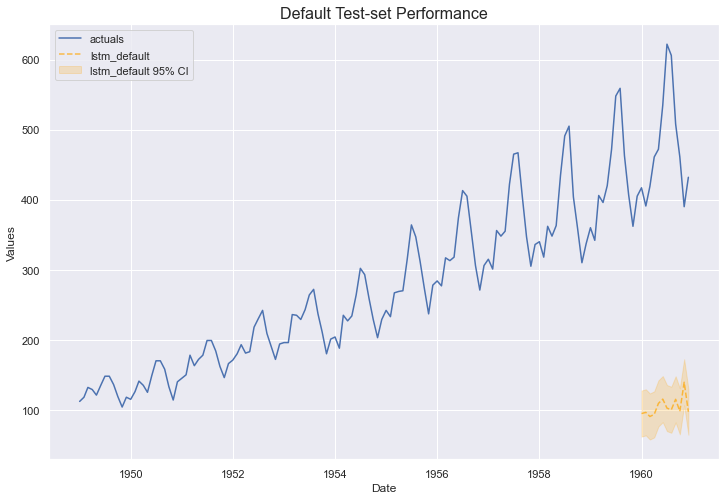

In [10]:
f.plot_test_set(ci=True)
plt.title('Default Test-set Performance',size=16)
plt.show()

### Attempt 2
- add more lags (2 years)

In [11]:
f.manual_forecast(call_me='lstm_24lags',lags=24)

4/4 [==============================] - 2s 8ms/step - loss: 0.3806


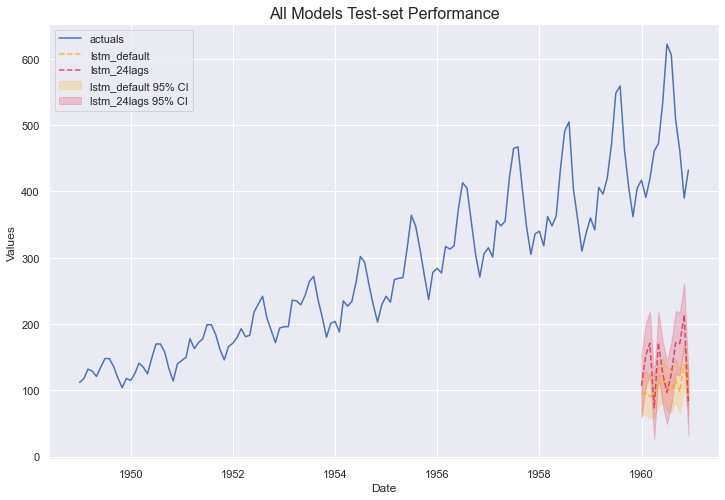

In [12]:
f.plot_test_set(ci=True)
plt.title('All Models Test-set Performance',size=16)
plt.show()

### Attempt 3
- Add more epochs (5)

In [13]:
f.manual_forecast(call_me='lstm_24lags_5epochs',lags=24,epochs=5,validation_split=.2,shuffle=True)

Epoch 1/5
3/3 [==============================] - 3s 289ms/step - loss: 0.4773 - val_loss: 0.1969
Epoch 2/5
3/3 [==============================] - 0s 18ms/step - loss: 0.4699 - val_loss: 0.1916
Epoch 3/5
3/3 [==============================] - 0s 25ms/step - loss: 0.4627 - val_loss: 0.1864
Epoch 4/5
3/3 [==============================] - 0s 19ms/step - loss: 0.4557 - val_loss: 0.1813
Epoch 5/5
3/3 [==============================] - 0s 19ms/step - loss: 0.4487 - val_loss: 0.1763
Epoch 1/5
3/3 [==============================] - 2s 199ms/step - loss: 0.4621 - val_loss: 0.1785
Epoch 2/5
3/3 [==============================] - 0s 21ms/step - loss: 0.4529 - val_loss: 0.1723
Epoch 3/5
3/3 [==============================] - 0s 15ms/step - loss: 0.4437 - val_loss: 0.1661
Epoch 4/5
3/3 [==============================] - 0s 15ms/step - loss: 0.4345 - val_loss: 0.1599
Epoch 5/5
3/3 [==============================] - 0s 14ms/step - loss: 0.4251 - val_loss: 0.1535


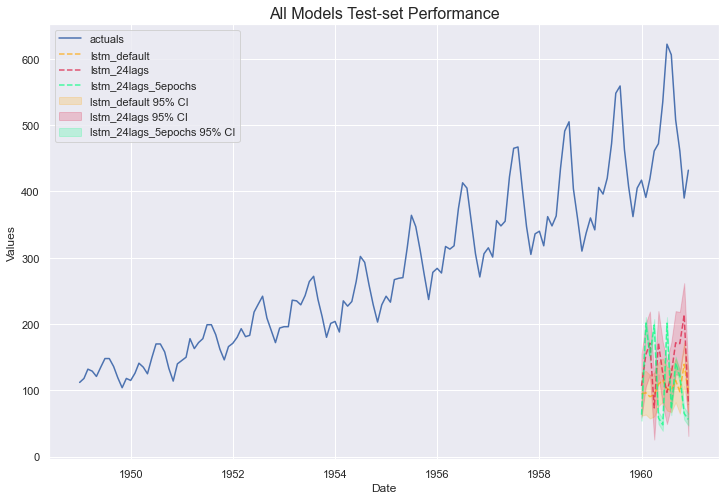

In [14]:
f.plot_test_set(ci=True)
plt.title('All Models Test-set Performance',size=16)
plt.show()

### Attempt 4
- Add layers and early stoping

In [15]:
from tensorflow.keras.callbacks import EarlyStopping
f.manual_forecast(call_me='lstm_24lags_earlystop_3layers',
                  lags=24,
                  epochs=25,
                  validation_split=.2,
                  shuffle=True,
                  callbacks=EarlyStopping(monitor='val_loss',
                                          patience=5),
                  lstm_layer_sizes=(16,16,16),
                  dropout=(0,0,0))

Epoch 1/25
3/3 [==============================] - 5s 440ms/step - loss: 0.4573 - val_loss: 0.1801
Epoch 2/25
3/3 [==============================] - 0s 28ms/step - loss: 0.4311 - val_loss: 0.1591
Epoch 3/25
3/3 [==============================] - 0s 27ms/step - loss: 0.3983 - val_loss: 0.1355
Epoch 4/25
3/3 [==============================] - 0s 28ms/step - loss: 0.3587 - val_loss: 0.1294
Epoch 5/25
3/3 [==============================] - 0s 29ms/step - loss: 0.3185 - val_loss: 0.1527
Epoch 6/25
3/3 [==============================] - 0s 28ms/step - loss: 0.2954 - val_loss: 0.1801
Epoch 7/25
3/3 [==============================] - 0s 28ms/step - loss: 0.2865 - val_loss: 0.1833
Epoch 8/25
3/3 [==============================] - 0s 29ms/step - loss: 0.2696 - val_loss: 0.1621
Epoch 9/25
3/3 [==============================] - 0s 29ms/step - loss: 0.2504 - val_loss: 0.1358
Epoch 1/25
3/3 [==============================] - 5s 520ms/step - loss: 0.4471 - val_loss: 0.1682
Epoch 2/25
3/3 [============

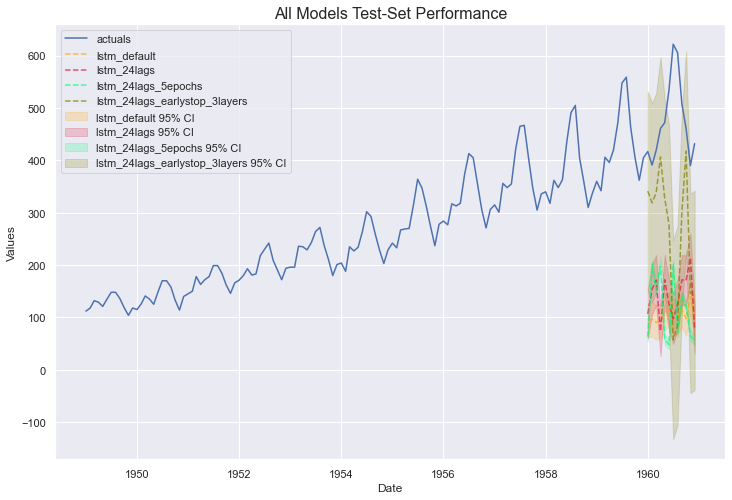

In [16]:
f.plot_test_set(ci=True)
plt.title('All Models Test-Set Performance',size=16)
plt.show()

### Attempt 5
- Add more lags (3 years)

Epoch 1/15
3/3 [==============================] - 6s 618ms/step - loss: 0.4792 - val_loss: 0.1935
Epoch 2/15
3/3 [==============================] - 0s 52ms/step - loss: 0.3668 - val_loss: 0.1192
Epoch 3/15
3/3 [==============================] - 0s 58ms/step - loss: 0.2181 - val_loss: 0.1265
Epoch 4/15
3/3 [==============================] - 0s 64ms/step - loss: 0.1264 - val_loss: 0.0571
Epoch 5/15
3/3 [==============================] - 0s 63ms/step - loss: 0.1361 - val_loss: 0.0721
Epoch 6/15
3/3 [==============================] - 0s 65ms/step - loss: 0.1219 - val_loss: 0.0740
Epoch 7/15
3/3 [==============================] - 0s 65ms/step - loss: 0.1034 - val_loss: 0.0533
Epoch 8/15
3/3 [==============================] - 0s 64ms/step - loss: 0.0978 - val_loss: 0.0528
Epoch 9/15
3/3 [==============================] - 0s 65ms/step - loss: 0.0939 - val_loss: 0.0520
Epoch 10/15
3/3 [==============================] - 0s 65ms/step - loss: 0.0923 - val_loss: 0.0555
Epoch 11/15
3/3 [===========

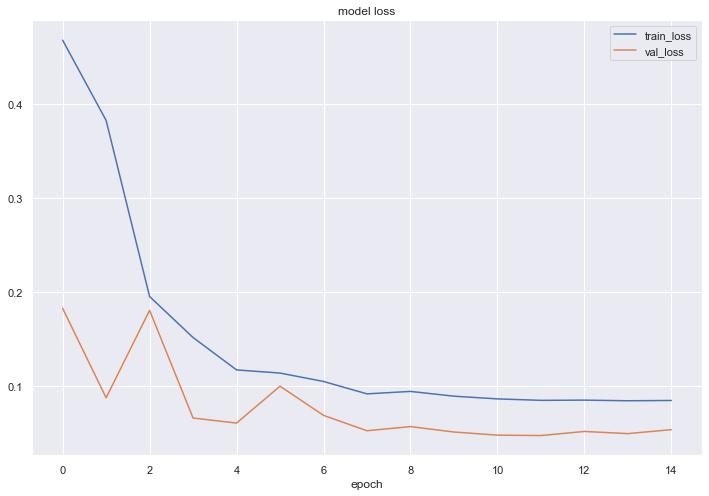

In [17]:
f.manual_forecast(call_me='lstm_24lags_4layers_15epochs',
                  lags=36,
                  batch_size=32,
                  epochs=15,
                  validation_split=.2,
                  shuffle=True,
                  activation='tanh',
                  optimizer='Adam',
                  learning_rate=0.001,
                  lstm_layer_sizes=(72,)*4,
                  dropout=(0,)*4,
                  plot_loss=True)

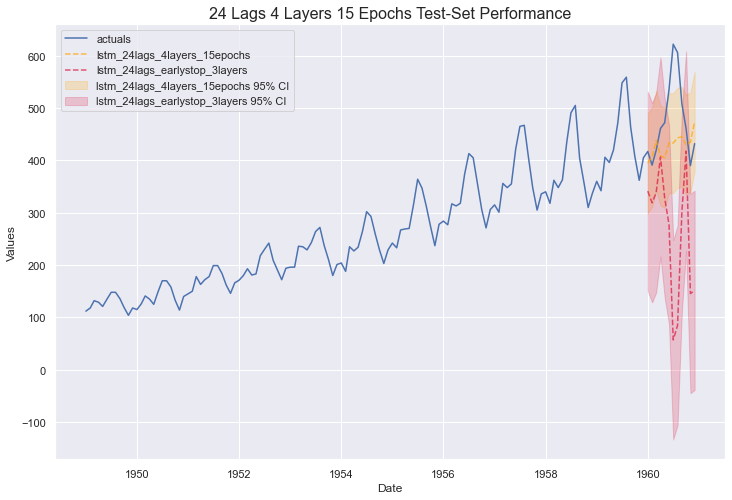

In [18]:
f.plot_test_set(order_by='LevelTestSetMAPE',models='top_2',ci=True)
plt.title('24 Lags 4 Layers 15 Epochs Test-Set Performance',size=16)
plt.show()

The last model run looks in the same ballpark as the actual series' trend, but still not great. Let's take things to the next level with this model by adding many more layers and training epochs.

### Attempt 6
- add more layers (15) and epochs (300)

Epoch 1/300
5/5 [==============================] - 31s 2s/step - loss: 0.4530 - val_loss: 0.3248
Epoch 2/300
5/5 [==============================] - 1s 285ms/step - loss: 0.1959 - val_loss: 0.0779
Epoch 3/300
5/5 [==============================] - 2s 327ms/step - loss: 0.1996 - val_loss: 0.2835
Epoch 4/300
5/5 [==============================] - 2s 293ms/step - loss: 0.1443 - val_loss: 0.1653
Epoch 5/300
5/5 [==============================] - 1s 291ms/step - loss: 0.1602 - val_loss: 0.2115
Epoch 6/300
5/5 [==============================] - 1s 294ms/step - loss: 0.1406 - val_loss: 0.2488
Epoch 7/300
5/5 [==============================] - 1s 298ms/step - loss: 0.1413 - val_loss: 0.1913
Epoch 8/300
5/5 [==============================] - 2s 305ms/step - loss: 0.1325 - val_loss: 0.2403
Epoch 9/300
5/5 [==============================] - 1s 295ms/step - loss: 0.1291 - val_loss: 0.1229
Epoch 10/300
5/5 [==============================] - 1s 300ms/step - loss: 0.1048 - val_loss: 0.1546
Epoch 11/30

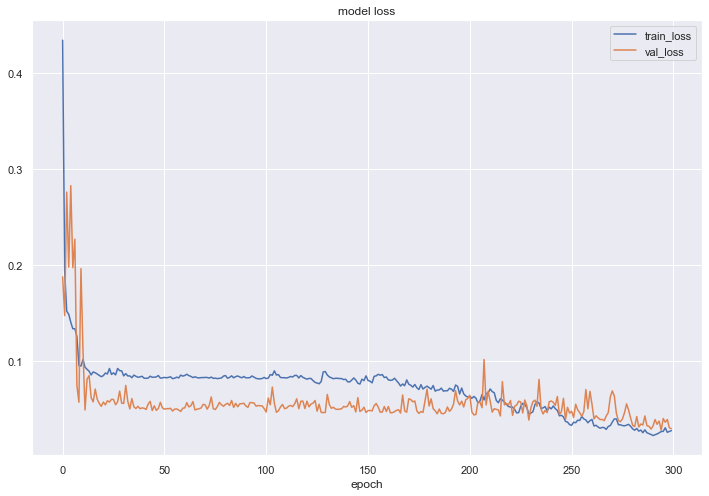

In [19]:
f.manual_forecast(call_me='lstm_best',
                  lags=36,
                  batch_size=16,
                  epochs=300,
                  validation_split=.2,
                  shuffle=True,
                  activation='tanh',
                  optimizer='Adam',
                  learning_rate=0.001,
                  lstm_layer_sizes=(100,)*15,
                  dropout=(0,)*15,
                  plot_loss=True)

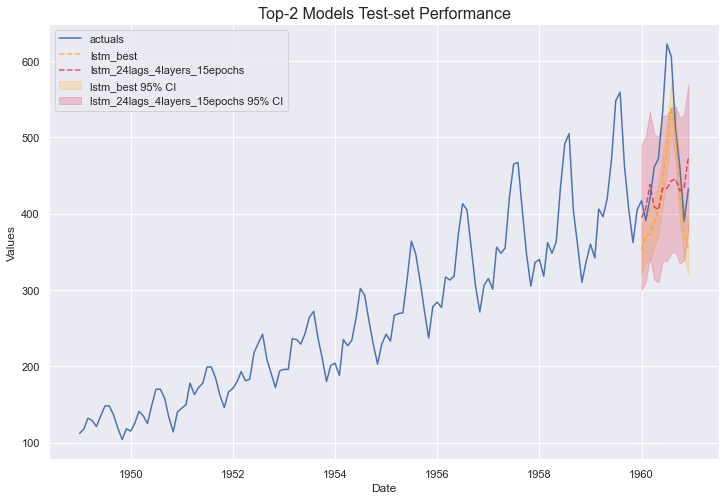

In [20]:
f.plot_test_set(order_by='LevelTestSetMAPE',models='top_2',ci=True)
plt.title('Top-2 Models Test-set Performance',size=16)
plt.show()

Finally, an LSTM model that looks somewhat believable, but it took a lot of work and took a long time to evaluate. Let's see if we can outpace this performance with a simple linear regression model.

## Prepare Forecast for MLR
- Test length already set
- Forecast horizon already set
- Add lags (24) - for MLR, these are added as regressors, not specified when calling the model (unlike LSTM)
- Add seasonal regressors (month, quarter - using dummy vars)
- Add year variable
- Add time trend
- Difference data since it is not stationary

In [21]:
f.add_ar_terms(24)
f.add_seasonal_regressors('month','quarter',dummy=True)
f.add_seasonal_regressors('year')
f.add_time_trend()
f.diff()

## MLR Modeling

In [22]:
f.set_estimator('mlr')
f.manual_forecast()

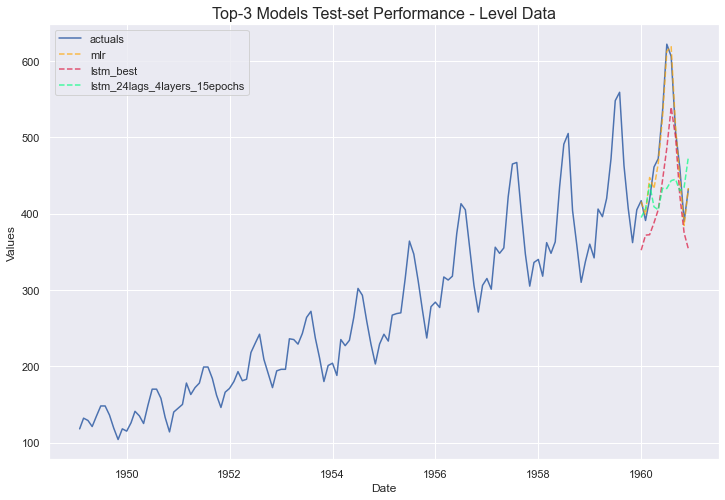

In [23]:
f.plot_test_set(order_by='LevelTestSetMAPE',models='top_3')
plt.title('Top-3 Models Test-set Performance - Level Data',size=16)
plt.show()

It is obvious that with much less work, we find a significantly better model. LSTM is not always suited for small datasets.

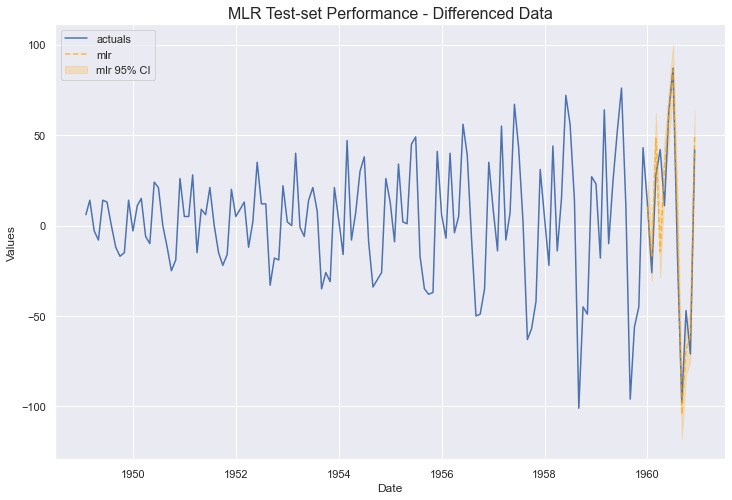

In [24]:
f.plot_test_set(models='mlr',ci=True)
plt.title('MLR Test-set Performance - Differenced Data',size=16)
plt.show()

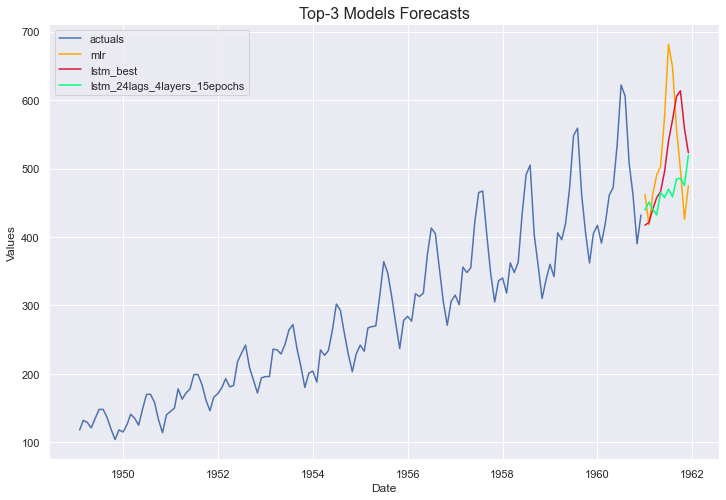

In [25]:
f.plot(order_by='LevelTestSetMAPE',models='top_3')
plt.title('Top-3 Models Forecasts',size=16)
plt.show()

## Benchmarking

In [26]:
f.export('model_summaries',determine_best_by='LevelTestSetMAPE')[
    ['ModelNickname','LevelTestSetMAPE','LevelTestSetRMSE','LevelTestSetR2','best_model']
]

,ModelNickname,LevelTestSetMAPE,LevelTestSetRMSE,LevelTestSetR2,best_model
0,mlr,0.023420,13.932124,0.964960,True
1,lstm_best,0.119243,68.053877,0.163940,False
2,lstm_24lags_4layers_15epochs,0.129948,86.405841,-0.347776,False
3,lstm_24lags_earlystop_3layers,0.417307,270.996087,-12.257378,False
4,lstm_24lags,0.698640,351.495204,-21.303366,False
5,lstm_24lags_5epochs,0.753630,372.805206,-24.089705,False
6,lstm_default,0.775769,379.507789,-24.999979,False


## Export Results

### Export forecasts

In [27]:
f.export_forecasts_with_cis('mlr')

,DATE,UpperForecast,Forecast,LowerForecast,ModelNickname,CILevel
0,1961-01-01,44.317296,30.246319,16.175341,mlr,0.95
1,1961-02-01,-30.451754,-44.522731,-58.593708,mlr,0.95
2,1961-03-01,57.748916,43.677939,29.606962,mlr,0.95
3,1961-04-01,43.134402,29.063425,14.992448,mlr,0.95
4,1961-05-01,26.468367,12.397390,-1.673587,mlr,0.95
5,1961-06-01,87.330962,73.259985,59.189008,mlr,0.95
6,1961-07-01,119.611803,105.540825,91.469848,mlr,0.95
7,1961-08-01,-19.516167,-33.587144,-47.658121,mlr,0.95
8,1961-09-01,-76.461348,-90.532325,-104.603302,mlr,0.95
9,1961-10-01,-45.301820,-59.372797,-73.443774,mlr,0.95


In [28]:
f.export_forecasts_with_cis('lstm_best')

,DATE,UpperForecast,Forecast,LowerForecast,ModelNickname,CILevel
0,1961-01-01,450.515897,417.223068,383.930238,lstm_best,0.95
1,1961-02-01,454.517386,421.224556,387.931727,lstm_best,0.95
2,1961-03-01,473.276636,439.983806,406.690977,lstm_best,0.95
3,1961-04-01,490.742308,457.449478,424.156649,lstm_best,0.95
4,1961-05-01,499.524204,466.231375,432.938545,lstm_best,0.95
5,1961-06-01,529.116206,495.823376,462.530547,lstm_best,0.95
6,1961-07-01,573.097535,539.804706,506.511876,lstm_best,0.95
7,1961-08-01,604.443835,571.151006,537.858176,lstm_best,0.95
8,1961-09-01,638.595086,605.302256,572.009427,lstm_best,0.95
9,1961-10-01,646.745152,613.452323,580.159493,lstm_best,0.95


### Export test-set preds

In [29]:
f.export_test_set_preds_with_cis('mlr')

,DATE,UpperPreds,Preds,Actuals,LowerPreds,ModelNickname,CILevel
0,1960-01-01,24.672688,10.601711,12.0,-3.469267,mlr,0.95
1,1960-02-01,-2.652120,-16.723097,-26.0,-30.794074,mlr,0.95
2,1960-03-01,62.492948,48.421971,28.0,34.350993,mlr,0.95
3,1960-04-01,-0.495233,-14.566210,42.0,-28.637188,mlr,0.95
4,1960-05-01,46.954922,32.883945,11.0,18.812968,mlr,0.95
5,1960-06-01,74.969007,60.898029,63.0,46.827052,mlr,0.95
6,1960-07-01,100.275627,86.204650,87.0,72.133673,mlr,0.95
7,1960-08-01,20.076173,6.005196,-16.0,-8.065781,mlr,0.95
8,1960-09-01,-90.174495,-104.245472,-98.0,-118.316449,mlr,0.95
9,1960-10-01,-54.550094,-68.621071,-47.0,-82.692048,mlr,0.95


In [30]:
f.export_test_set_preds_with_cis('lstm_best')

,DATE,UpperPreds,Preds,Actuals,LowerPreds,ModelNickname,CILevel
0,1960-01-01,385.373443,352.080613,417.0,318.787784,lstm_best,0.95
1,1960-02-01,405.112817,371.819988,391.0,338.527158,lstm_best,0.95
2,1960-03-01,405.630079,372.337250,419.0,339.044420,lstm_best,0.95
3,1960-04-01,421.275266,387.982436,461.0,354.689607,lstm_best,0.95
4,1960-05-01,438.305395,405.012566,472.0,371.719736,lstm_best,0.95
5,1960-06-01,477.519533,444.226704,535.0,410.933874,lstm_best,0.95
6,1960-07-01,519.154792,485.861963,622.0,452.569134,lstm_best,0.95
7,1960-08-01,572.659983,539.367153,606.0,506.074324,lstm_best,0.95
8,1960-09-01,533.544182,500.251353,508.0,466.958523,lstm_best,0.95
9,1960-10-01,457.327931,424.035101,461.0,390.742272,lstm_best,0.95


### Export Feature Info
- For MLR only

In [31]:
f.save_feature_importance()
f.export_feature_importance('mlr')

,weight,std
feature,,
AR1,0.353119,0.035858
AR12,0.240569,0.008579
AR4,0.212699,0.036834
AR10,0.183908,0.019656
AR21,0.128429,0.010093
AR13,0.111962,0.015230
AR18,0.106690,0.013365
AR2,0.090244,0.002529
AR20,0.088816,0.010303
